# Using the Izhikevich neuron model

The [Izhikevich neuron model](
http://www.izhikevich.org/publications/spikes.htm)
is a quadratic integrate-and-fire type model
with a recovery variable.
It is able to replicate several characteristics
of biological neurons while remaining
computationally efficient.

The Izhikevich neuron model is implemented in Nengo.
To use it, use a `nengo.Izhikevich` instance
as the `neuron_type` of an ensemble.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import nengo
from nengo.utils.ensemble import tuning_curves
from nengo.utils.matplotlib import rasterplot

In [2]:
with nengo.Network(seed=0) as model:
    u = nengo.Node(lambda t: np.sin(2 * np.pi * t))
    ens = nengo.Ensemble(10, dimensions=1, neuron_type=nengo.Izhikevich())
    nengo.Connection(u, ens)

In addition to the usual decoded output and neural activity
that can always be probed,
you can probe the voltage and recovery terms
of the Izhikevich model.

In [3]:
with model:
    out_p = nengo.Probe(ens, synapse=0.03)
    spikes_p = nengo.Probe(ens.neurons)
    voltage_p = nengo.Probe(ens.neurons, 'voltage')
    recovery_p = nengo.Probe(ens.neurons, 'recovery')

Simulating this model shows that we are able
to decode a time-varying scalar with
an ensemble of Izhikevich neurons.

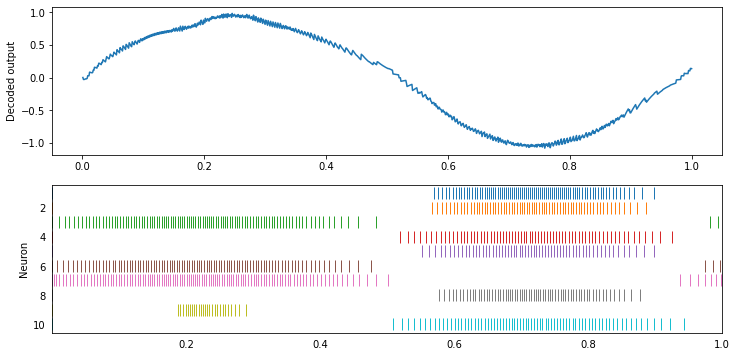

In [4]:
with nengo.Simulator(model) as sim:
    sim.run(1.0)

t = sim.trange()
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t, sim.data[out_p])
plt.ylabel("Decoded output")
ax = plt.subplot(2, 1, 2)
rasterplot(t, sim.data[spikes_p], ax=ax)
plt.ylabel("Neuron");

One thing you might notice is a slight bump in the decoded value
at the start of the simulation.
This occurs because of the adaptive nature of the Izhikevic model;
it is easier to initiate the first spike than it is to ellicit
further spikes.

Let's use a constant input and
look at the first 100 ms of the simulation in more detail
to see the difference between the first spike and subsequent spikes.

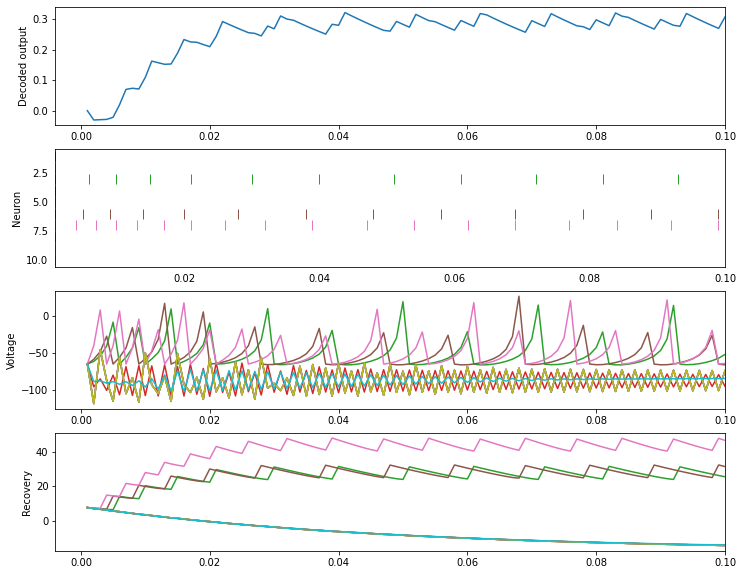

In [5]:
def izh_plot(sim):
    t = sim.trange()
    plt.figure(figsize=(12, 10))
    plt.subplot(4, 1, 1)
    plt.plot(t, sim.data[out_p])
    plt.ylabel("Decoded output")
    plt.xlim(right=t[-1])
    ax = plt.subplot(4, 1, 2)
    rasterplot(t, sim.data[spikes_p], ax=ax)
    plt.ylabel("Neuron")
    plt.xlim(right=t[-1])
    plt.subplot(4, 1, 3)
    plt.plot(t, sim.data[voltage_p])
    plt.ylabel("Voltage")
    plt.xlim(right=t[-1])
    plt.subplot(4, 1, 4)
    plt.plot(t, sim.data[recovery_p])
    plt.ylabel("Recovery")
    plt.xlim(right=t[-1])


u.output = 0.2
with nengo.Simulator(model) as sim:
    sim.run(0.1)
izh_plot(sim)

Those neurons that have an encoder of -1
receive negative current, and therefore
remain at a low voltage.

Those neurons that have an encoder of 1
receive positive current, and start spiking rapidly.
However, as they spike, the recovery variable grows,
until it reaches a balance with the voltage
such that the cells spike regularly.

This occurs because, by default,
we use a set of parameters
that models a "regular spiking" neuron.
We can use parameters
that model several different
classes of neurons instead.

### Intrinsically bursting (IB)

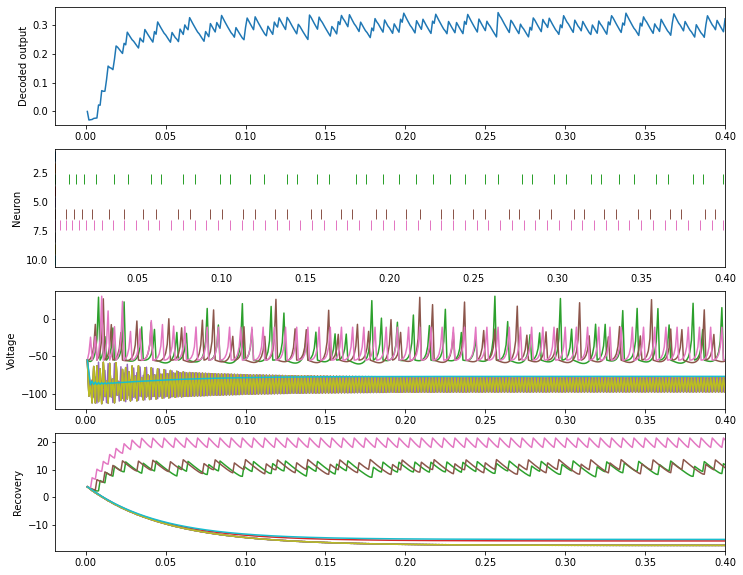

In [6]:
ens.neuron_type = nengo.Izhikevich(reset_voltage=-55, reset_recovery=4)
with nengo.Simulator(model) as sim:
    sim.run(0.4)
izh_plot(sim)

### Chattering (CH)

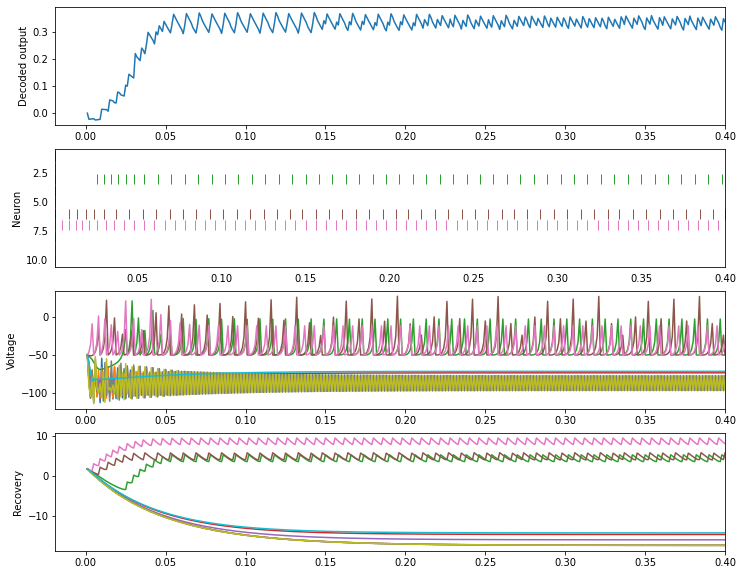

In [7]:
ens.neuron_type = nengo.Izhikevich(reset_voltage=-50, reset_recovery=2)
with nengo.Simulator(model) as sim:
    sim.run(0.4)
izh_plot(sim)

### Fast spiking (FS)

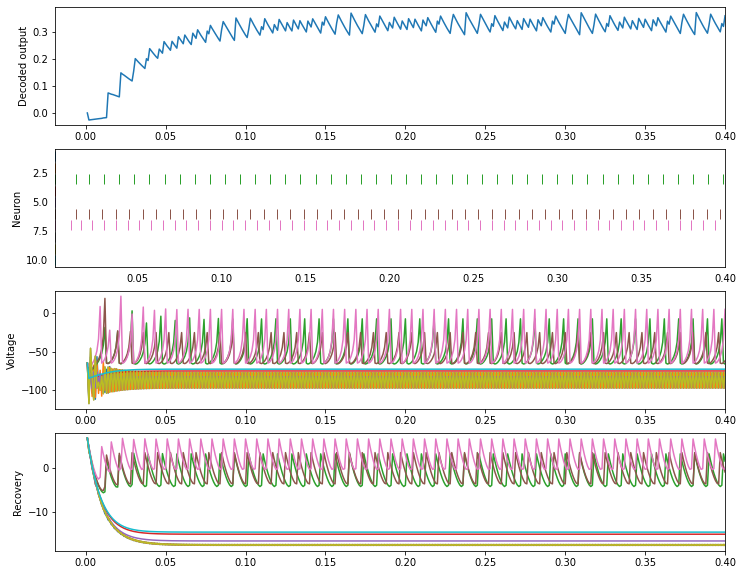

In [8]:
ens.neuron_type = nengo.Izhikevich(tau_recovery=0.1)
with nengo.Simulator(model) as sim:
    sim.run(0.4)
izh_plot(sim)

### Low-threshold spiking (LTS)

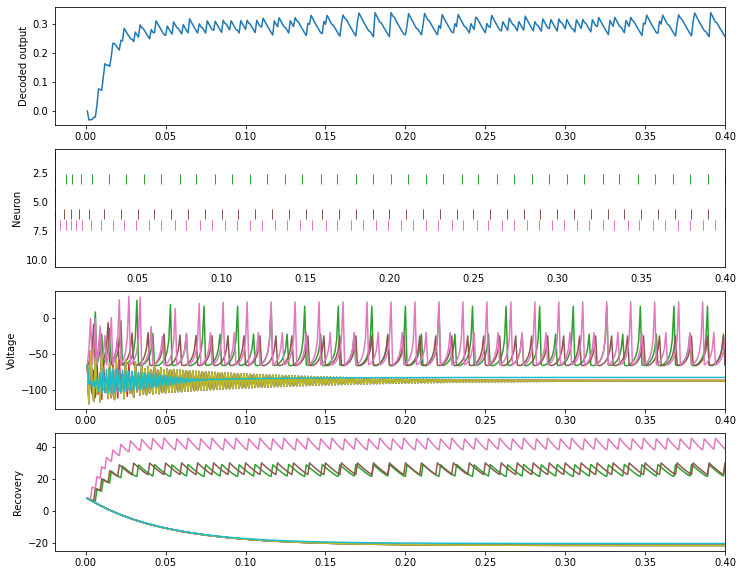

In [9]:
ens.neuron_type = nengo.Izhikevich(coupling=0.25)
with nengo.Simulator(model) as sim:
    sim.run(0.4)
izh_plot(sim)

### Resonator (RZ)

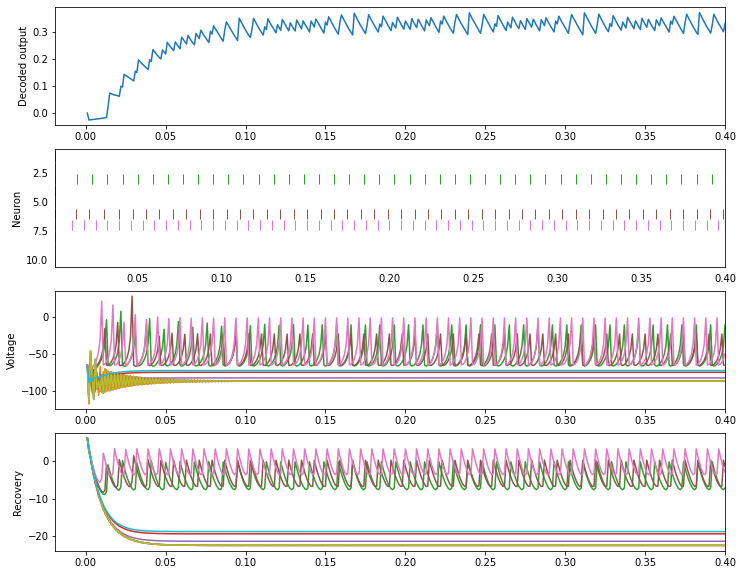

In [10]:
ens.neuron_type = nengo.Izhikevich(tau_recovery=0.1, coupling=0.26)
with nengo.Simulator(model) as sim:
    sim.run(0.4)
izh_plot(sim)

## Caveats

Unfortunately, Izhikevich neurons can't necessarily
be used in all of the situations that LIFs are used,
due to the more complex dynamics illustrated above.

The way that Nengo encodes and decodes information
with neurons is informed by the tuning curves
of those neurons.
With Izhikevich neurons, the firing rate
with a certain input current `J` changes;
the spike rate is initially higher due
to the adaptation illustrated above.

We try our best to generate tuning curves
for Izhikevich neurons.

In [11]:
with nengo.Network(seed=0) as model:
    u = nengo.Node(lambda t: np.sin(2 * np.pi * t))
    ens = nengo.Ensemble(30, dimensions=1, neuron_type=nengo.Izhikevich())
    nengo.Connection(u, ens)
    out_p = nengo.Probe(ens, synapse=0.03)

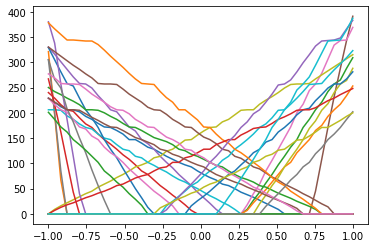

In [12]:
with nengo.Simulator(model) as sim:
    plt.figure()
    plt.plot(*tuning_curves(ens, sim));

But these are not as accurate and clean
as LIF curves, which is detrimental
for function decoding.

In [13]:
u.output = lambda t: np.sin(2 * np.pi * t)
with model:
    square = nengo.Ensemble(30, dimensions=1, neuron_type=nengo.Izhikevich())
    nengo.Connection(ens, square, function=lambda x: x ** 2)
    square_p = nengo.Probe(square, synapse=0.03)

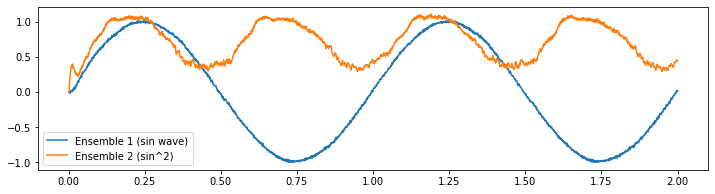

In [14]:
with nengo.Simulator(model) as sim:
    sim.run(2.0)

t = sim.trange()
plt.figure(figsize=(12, 3))
plt.plot(t, sim.data[out_p], label="Ensemble 1 (sin wave)")
plt.plot(t, sim.data[square_p], label="Ensemble 2 (sin^2)")
plt.legend(loc="best");

Some of these weird dynamics
can be overcome by using Izhikevich
neurons with different parameters.

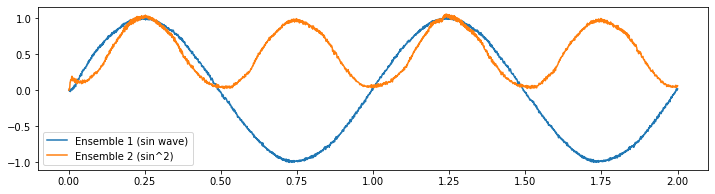

In [15]:
square.neuron_type = nengo.Izhikevich(tau_recovery=0.2)

with nengo.Simulator(model) as sim:
    sim.run(2.0)

t = sim.trange()
plt.figure(figsize=(12, 3))
plt.plot(t, sim.data[out_p], label="Ensemble 1 (sin wave)")
plt.plot(t, sim.data[square_p], label="Ensemble 2 (sin^2)")
plt.legend(loc="best");

Generally, however, Izhikevich neurons are most useful
when trying to match known physiological properties
of the system being modelled.